In [1]:
!ls /content


archive.zip  extracted_data  sample_data


In [2]:
import zipfile, os

ZIP_PATH = '/content/archive.zip'  # change this to match your uploaded file name
EXTRACT_DIR = '/content/extracted_data'

print("ZIP_PATH exists?", os.path.exists(ZIP_PATH))

# Extract
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_DIR)

print("Extracted content:")
!ls /content/extracted_data


ZIP_PATH exists? True
Extracted content:
Testing  Training


In [ ]:
import os
import glob
from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import img_as_float, exposure
from skimage.filters import threshold_otsu
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
from scipy.signal import wiener
from scipy.ndimage import median_filter as scipy_median
import zipfile

# ---------------------- Anisotropic diffusion implementation ----------------------

def anisotropic_diffusion(img, niter=10, kappa=30, gamma=0.1, option=1):
    img = img.astype(np.float32)
    diff = img.copy()

    for _ in range(niter):
        north = np.roll(diff, 1, axis=0)
        south = np.roll(diff, -1, axis=0)
        west  = np.roll(diff, 1, axis=1)
        east  = np.roll(diff, -1, axis=1)

        deltaN = north - diff
        deltaS = south - diff
        deltaW = west  - diff
        deltaE = east  - diff

        if option == 1:
            cN = np.exp(-(deltaN / kappa)**2)
            cS = np.exp(-(deltaS / kappa)**2)
            cW = np.exp(-(deltaW / kappa)**2)
            cE = np.exp(-(deltaE / kappa)**2)
        else:
            cN = 1.0 / (1.0 + (deltaN / kappa)**2)
            cS = 1.0 / (1.0 + (deltaS / kappa)**2)
            cW = 1.0 / (1.0 + (deltaW / kappa)**2)
            cE = 1.0 / (1.0 + (deltaE / kappa)**2)

        diff += gamma * (cN * deltaN + cS * deltaS + cW * deltaW + cE * deltaE)

    return diff


# ---------------------- Metric Functions ----------------------

def dice_coef(mask_gt, mask_pred, eps=1e-9):
    mask_gt = mask_gt.astype(bool)
    mask_pred = mask_pred.astype(bool)
    inter = np.logical_and(mask_gt, mask_pred).sum()
    union = mask_gt.sum() + mask_pred.sum()
    return (2.0 * inter + eps) / (union + eps)

def iou_score(mask_gt, mask_pred, eps=1e-9):
    mask_gt = mask_gt.astype(bool)
    mask_pred = mask_pred.astype(bool)
    inter = np.logical_and(mask_gt, mask_pred).sum()
    uni = np.logical_or(mask_gt, mask_pred).sum()
    return (inter + eps) / (uni + eps)


# ---------------------- Filter Processing ----------------------

def process_image(img, params):
    results = {}

    # Gaussian
    sigma = params.get('gauss_sigma', 1.0)
    gauss = cv2.GaussianBlur((img * 255).astype(np.uint8), (0,0), sigma)
    results['gaussian'] = gauss.astype(np.float32) / 255.0

    # Median
    k = params.get('median_k', 3)
    med = cv2.medianBlur((img * 255).astype(np.uint8), k)
    results['median'] = med.astype(np.float32) / 255.0

    # Wiener
    win = wiener(img, (params.get('wiener_size',5), params.get('wiener_size',5)))
    results['wiener'] = np.clip(win, 0, 1)

    # Anisotropic diffusion
    ad = anisotropic_diffusion(img,
                               niter=params.get('ad_niter',10),
                               kappa=params.get('ad_kappa',30),
                               gamma=params.get('ad_gamma',0.1),
                               option=params.get('ad_option',1))
    ad = np.clip(ad, 0, 1)
    results['anisotropic'] = ad

    # Hybrid (AD + Median)
    ad_med = cv2.medianBlur((ad * 255).astype(np.uint8), k).astype(np.float32)/255.0
    results['hybrid_ad_median'] = ad_med

    return results


# ---------------------- Metric Computation ----------------------

def compute_metrics_pair(orig, filtered, mask_gt=None):
    psnr = compare_psnr(orig, filtered, data_range=1.0)
    ssim = compare_ssim(orig, filtered, data_range=1.0)

    metrics = {'psnr': psnr, 'ssim': ssim}

    try:
        thresh_o = threshold_otsu((orig*255).astype(np.uint8)) / 255.0
        mask_orig = (orig >= thresh_o).astype(np.uint8)

        thresh_f = threshold_otsu((filtered*255).astype(np.uint8)) / 255.0
        mask_filt = (filtered >= thresh_f).astype(np.uint8)

        dice = dice_coef(mask_orig, mask_filt)
        iou = iou_score(mask_orig, mask_filt)
    except:
        dice = None
        iou = None

    metrics['dice'] = dice
    metrics['iou'] = iou

    return metrics


# ---------------------- Auto ZIP Extraction + Auto DATA_DIR ----------------------

def find_images_in_extracted(extract_dir):
    exts = ('*.png','*.jpg','*.jpeg','*.bmp','*.tif')
    images = []

    for root, dirs, files in os.walk(extract_dir):
        for ext in exts:
            images.extend(glob.glob(os.path.join(root, ext)))

    return images


# ---------------------- MAIN ----------------------

def main():
    ZIP_PATH = '/content/archive.zip'  # 🔥 CHANGE THIS to your uploaded zip filename
    EXTRACT_DIR = '/content/extracted_data'

    # --- Extract ZIP ---
    if os.path.exists(ZIP_PATH):
        print(f"Extracting {ZIP_PATH} ...")
        with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall(EXTRACT_DIR)
        print("Extraction complete.")
    else:
        print("❌ ZIP file not found.")
        return

    # --- Auto-detect images ---
    images = find_images_in_extracted(EXTRACT_DIR)

    if len(images) == 0:
        print("❌ No images found inside ZIP. Check folder structure.")
        return

    # Set DATA_DIR automatically
    DATA_DIR = os.path.dirname(images[0])
    print(f"✅ DATA_DIR automatically set to: {DATA_DIR}")

    OUTPUT_DIR = "./results"
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    params = {
        'gauss_sigma': 1.0,
        'median_k': 3,
        'wiener_size': 5,
        'ad_niter': 10,
        'ad_kappa': 30,
        'ad_gamma': 0.15,
        'ad_option': 1
    }

    aggregate = {k: {'psnr': [], 'ssim': [], 'dice': [], 'iou': []}
                 for k in ['gaussian','median','wiener','anisotropic','hybrid_ad_median']}

    # --- Process each image ---
    for fpath in tqdm(images, desc="Processing images"):
        img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        imgf = img_as_float(img)
        results = process_image(imgf, params)

        for name, filt_img in results.items():
            metrics = compute_metrics_pair(imgf, filt_img)
            for m in metrics:
                aggregate[name][m].append(metrics[m])

    print("\n=== Summary ===")
    for name, vals in aggregate.items():
        print(name)
        for m in vals:
            arr = np.array([v for v in vals[m] if v is not None])
            if len(arr) > 0:
                print(f"  {m}: {arr.mean():.4f} ± {arr.std():.4f}")

    print("\n✔ Results saved in:", OUTPUT_DIR)


if __name__ == "__main__":
    main()


Extracting /content/archive.zip ...
Extraction complete.
✅ DATA_DIR automatically set to: /content/extracted_data/Testing/glioma


Processing images:   0%|          | 0/7023 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/scipy/signal/_signaltools.py:1783: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
/usr/local/lib/python3.12/dist-packages/scipy/signal/_signaltools.py:1783: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)
Processing images: 100%|██████████| 7023/7023 [34:34<00:00,  3.39it/s]


=== Summary ===
gaussian
  psnr: 35.6794 ± 6.1755
  ssim: 0.9570 ± 0.0540
  dice: 0.9743 ± 0.0625
  iou: 0.9549 ± 0.0840
median
  psnr: 39.7881 ± 6.8260
  ssim: 0.9700 ± 0.0510
  dice: 0.9845 ± 0.0489
  iou: 0.9727 ± 0.0691
wiener
  psnr: 37.3361 ± 5.4616
  ssim: 0.9382 ± 0.0616
  dice: 0.9792 ± 0.0454
  iou: 0.9620 ± 0.0626
anisotropic
  psnr: 30.3405 ± 5.2319
  ssim: 0.8887 ± 0.0939
  dice: 0.9577 ± 0.0701
  iou: 0.9250 ± 0.0937
hybrid_ad_median
  psnr: 30.0515 ± 5.1621
  ssim: 0.8798 ± 0.0956
  dice: 0.9566 ± 0.0705
  iou: 0.9232 ± 0.0941

✔ Results saved in: ./results


In [ ]:
# ---------------------- PLOTTING FUNCTIONS ----------------------

def plot_comparison(original, filtered_dict, save_path=None):
    """
    Plot original image with all filtered outputs side-by-side.
    """
    num_filters = len(filtered_dict)
    plt.figure(figsize=(4 * (num_filters + 1), 4))

    # Plot original
    plt.subplot(1, num_filters + 1, 1)
    plt.imshow(original, cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Plot each filtered output
    idx = 2
    for name, img in filtered_dict.items():
        plt.subplot(1, num_filters + 1, idx)
        plt.imshow(img, cmap="gray")
        plt.title(name)
        plt.axis("off")
        idx += 1

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.close()


def plot_histograms(original, filtered_dict, save_path=None):
    """
    Plot intensity histograms of the original + all filtered images.
    """
    num_filters = len(filtered_dict)
    plt.figure(figsize=(5 * (num_filters + 1), 4))

    # Original histogram
    plt.subplot(1, num_filters + 1, 1)
    plt.hist(original.ravel(), bins=256)
    plt.title("Original Histogram")

    idx = 2
    for name, img in filtered_dict.items():
        plt.subplot(1, num_filters + 1, idx)
        plt.hist(img.ravel(), bins=256)
        plt.title(f"{name} Histogram")
        idx += 1

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.close()



Processing: Tr-gl_1083.jpg


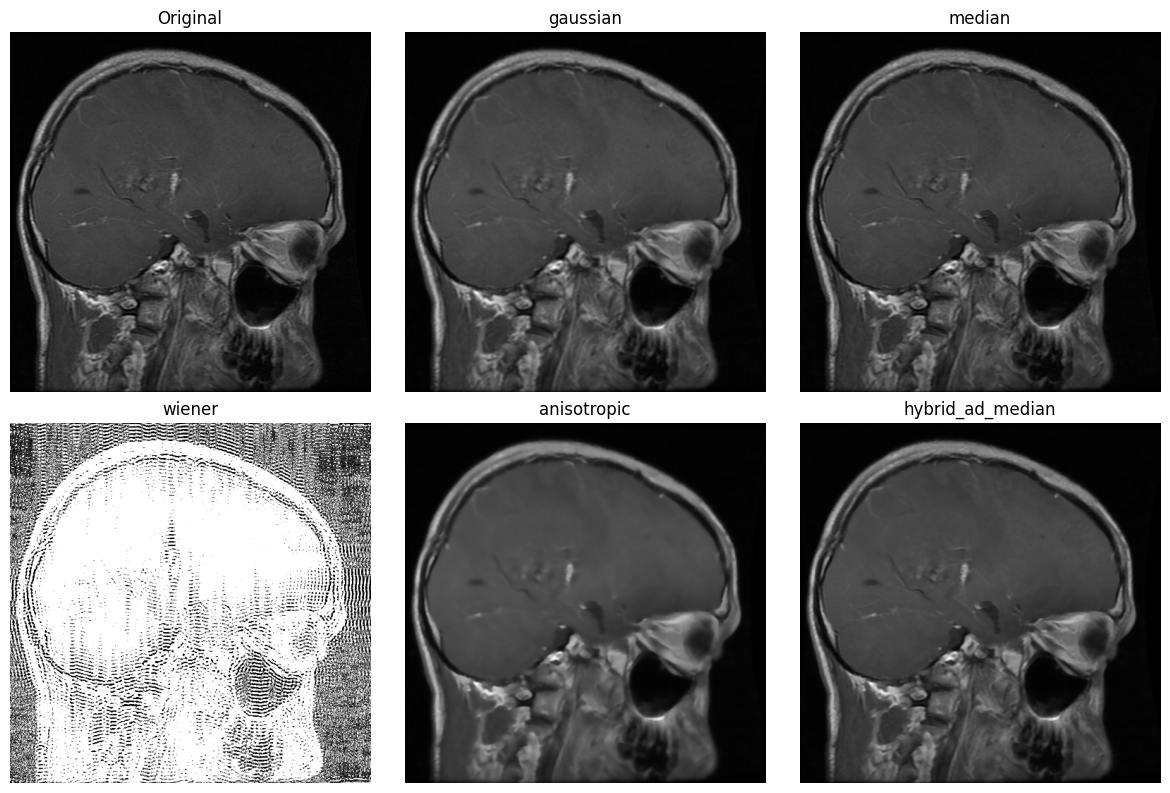

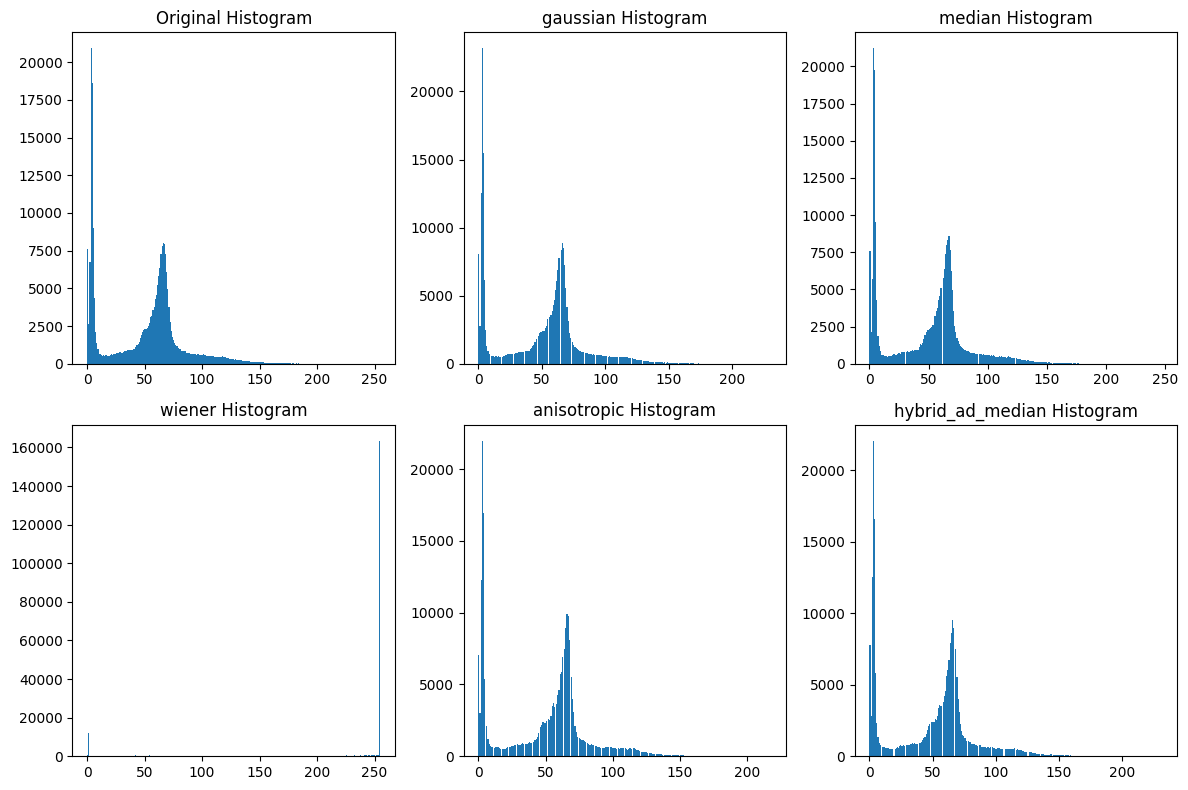


Processing: Tr-gl_1229.jpg


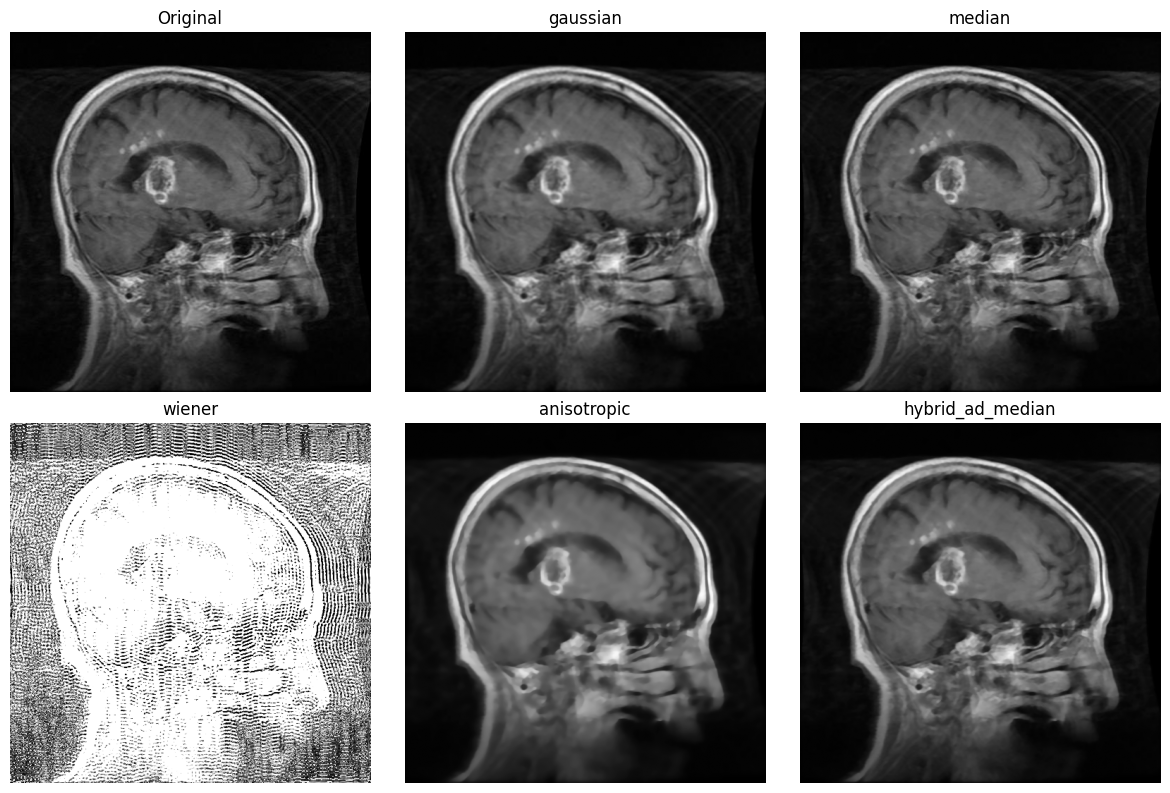

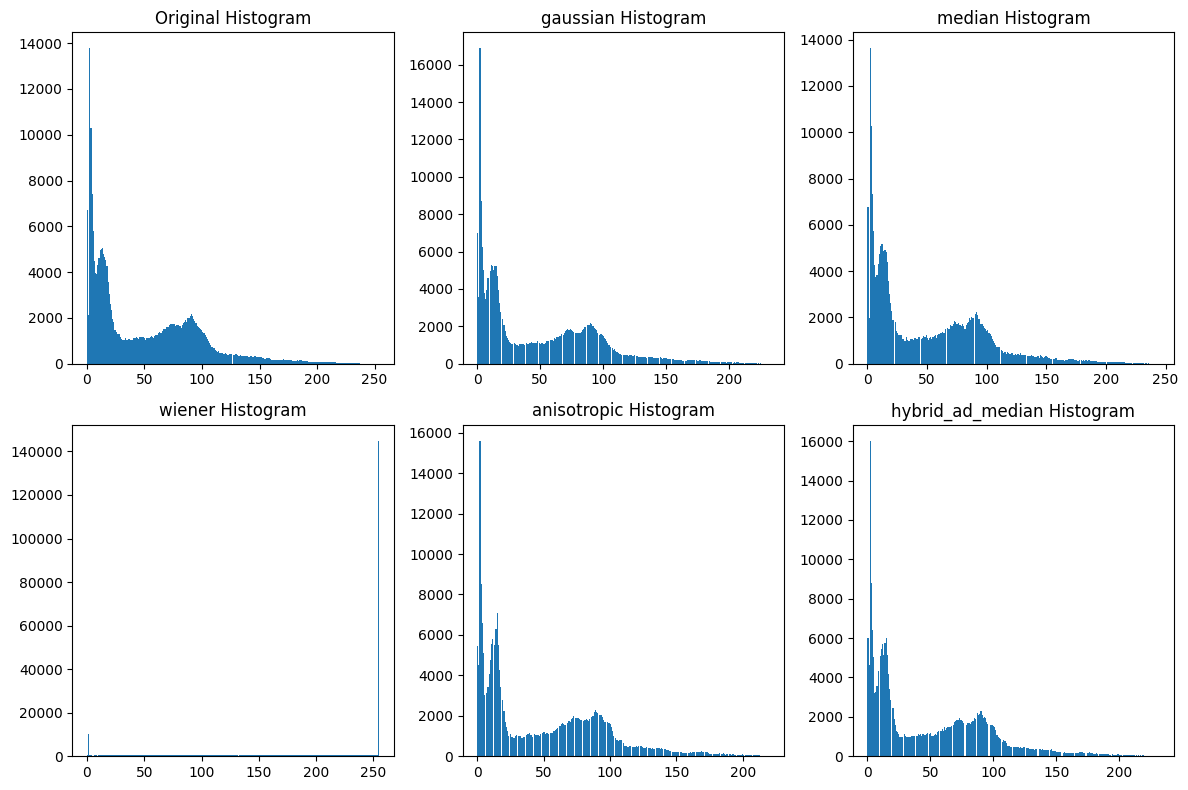


Processing: Tr-gl_1097.jpg


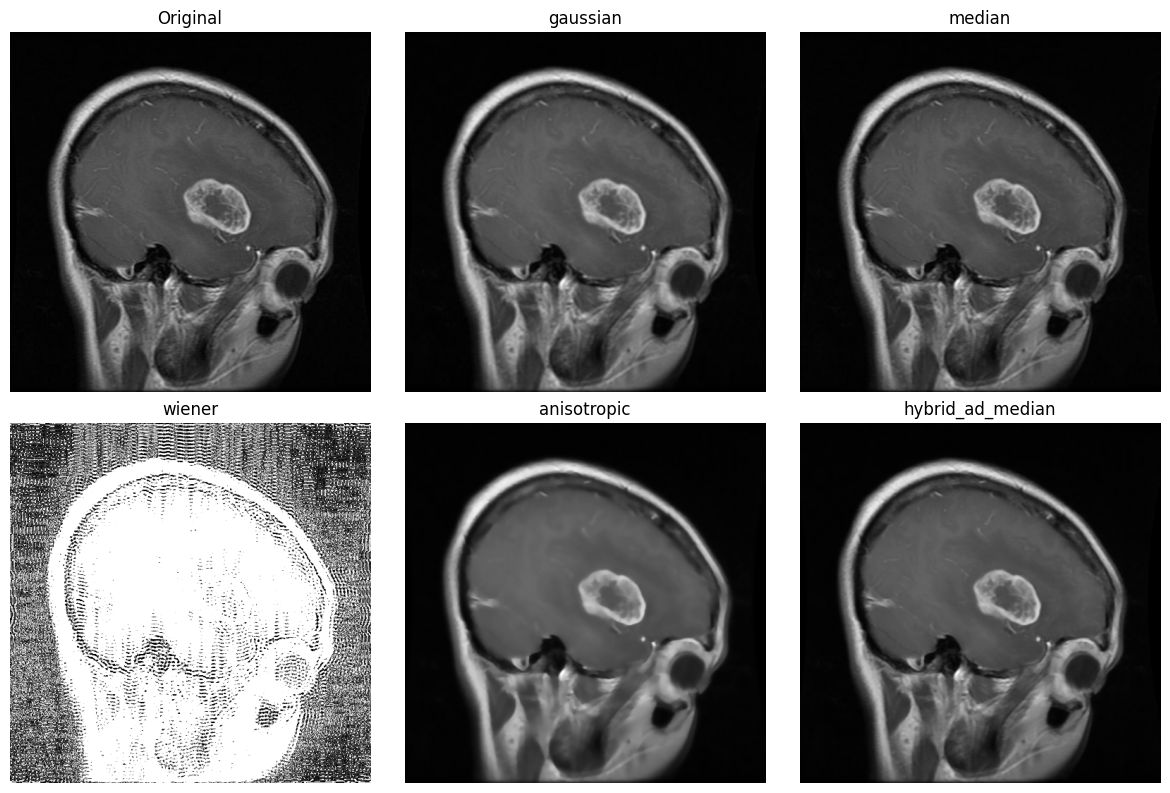

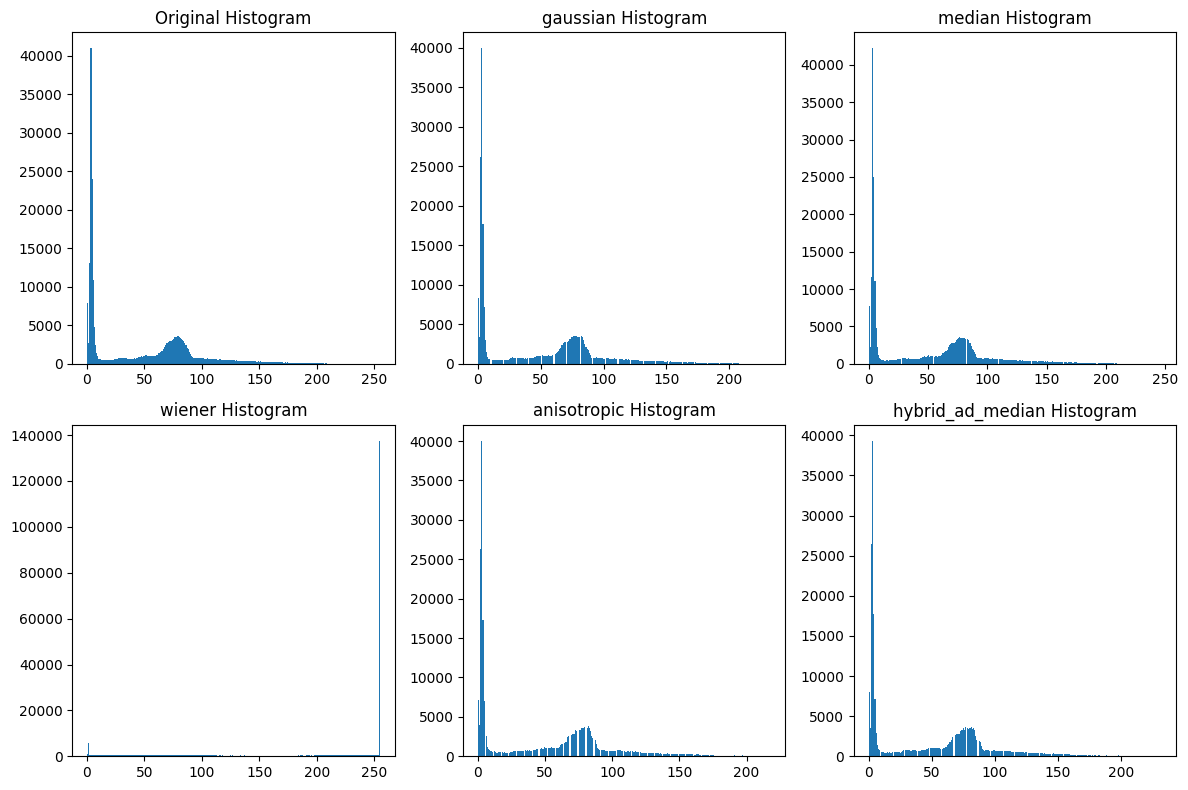


Processing: Tr-gl_1077.jpg


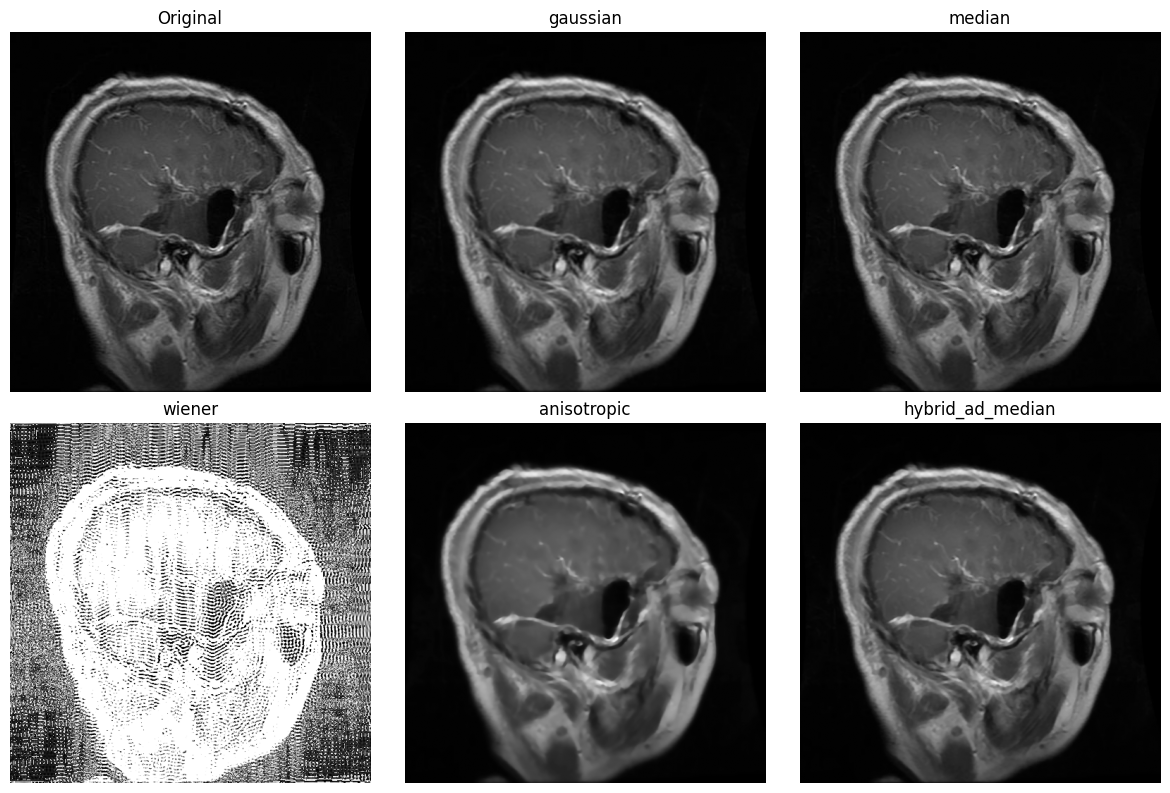

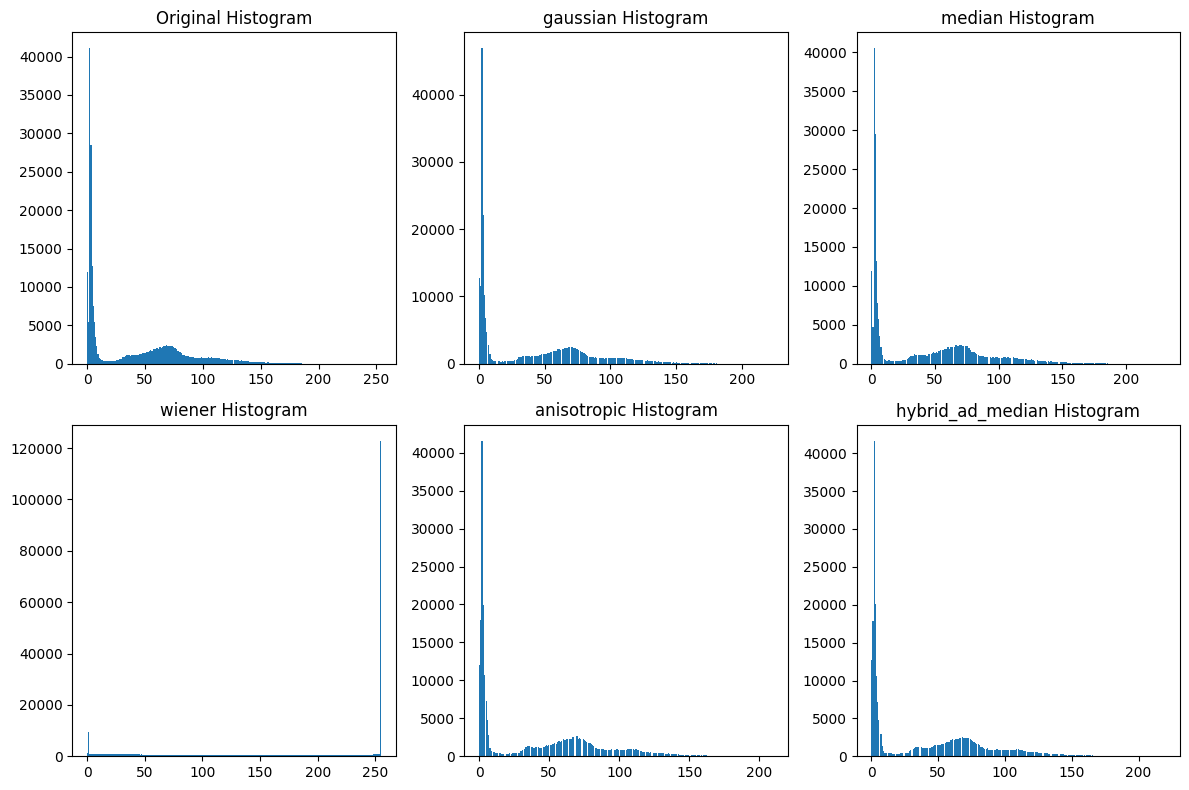


Processing: Tr-gl_0960.jpg


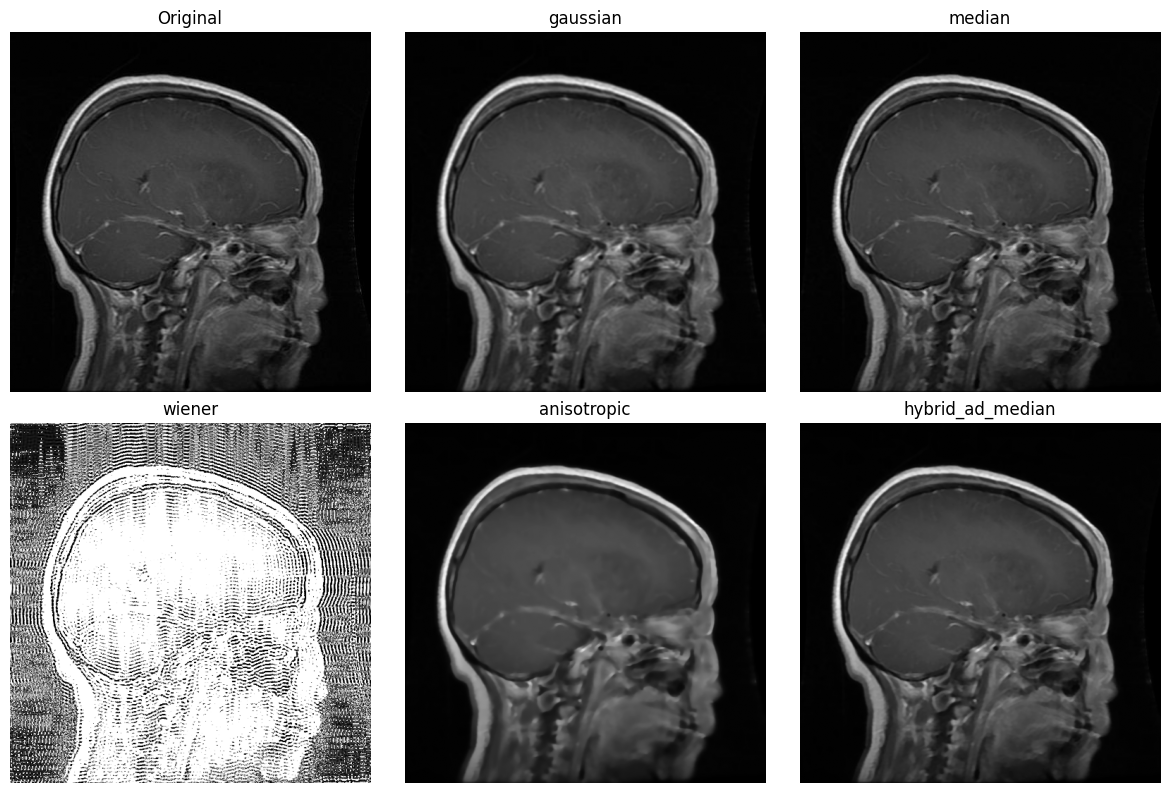

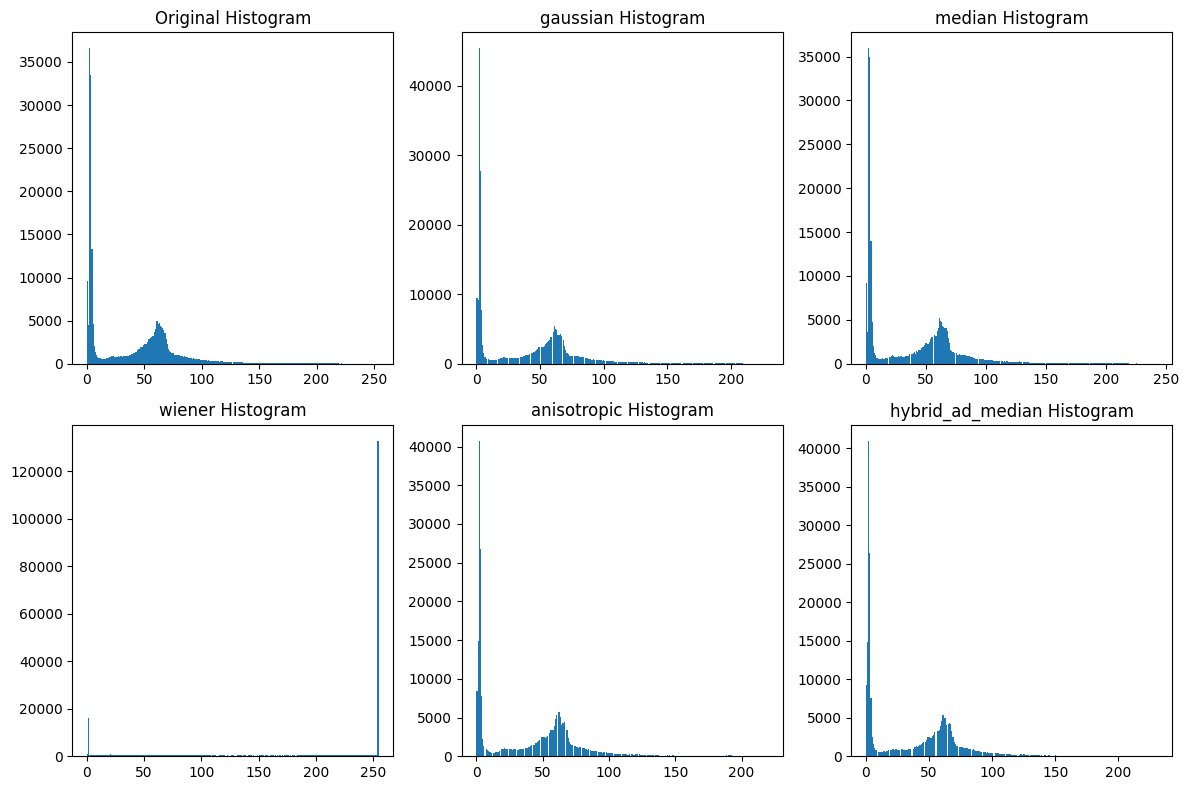

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.restoration import denoise_tv_chambolle, wiener
from scipy.ndimage import median_filter
from skimage.filters import gaussian

# ============================
# METRICS
# ============================
def psnr(original, filtered):
    mse = np.mean((original - filtered) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(255.0 / np.sqrt(mse))

def dice_coeff(gt, pred):
    gt = gt.astype(bool)
    pred = pred.astype(bool)
    inter = np.logical_and(gt, pred).sum()
    return (2 * inter) / (gt.sum() + pred.sum())

def iou_coeff(gt, pred):
    gt = gt.astype(bool)
    pred = pred.astype(bool)
    inter = np.logical_and(gt, pred).sum()
    union = np.logical_or(gt, pred).sum()
    return inter / union

# ============================
# LOAD ALL IMAGES
# ============================
IMAGE_FOLDER = "/content/extracted_data/Training/glioma"   # Update folder path
image_files = [f for f in os.listdir(IMAGE_FOLDER) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

if len(image_files) == 0:
    raise ValueError("No images found in the folder.")

# Limit to first 5 images
image_files = image_files[:5]

# ============================
# PROCESS EACH IMAGE
# ============================
for file in image_files:

    print("\nProcessing:", file)
    img = cv2.imread(os.path.join(IMAGE_FOLDER, file), 0)  # grayscale
    gt = img.copy()

    # ============================
    # FILTERS
    # ============================
    filtered = {
        "gaussian": (gaussian(img, sigma=1) * 255).astype(np.uint8),
        "median": median_filter(img, size=3).astype(np.uint8),
        "wiener": (wiener(img, np.ones((5, 5)), balance=0.1) * 255).astype(np.uint8),
        "anisotropic": (denoise_tv_chambolle(img, weight=0.1) * 255).astype(np.uint8),
        "hybrid_ad_median": (
                0.5 * denoise_tv_chambolle(img, weight=0.1) * 255 +
                0.5 * median_filter(img, size=3)
        ).astype(np.uint8)
    }

    # ============================
    # PLOT COMPARISON
    # ============================
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original")
    plt.axis("off")

    i = 2
    for name, fimg in filtered.items():
        plt.subplot(2, 3, i)
        plt.imshow(fimg, cmap='gray')
        plt.title(name)
        plt.axis("off")
        i += 1

    plt.tight_layout()
    plt.show()

    # ============================
    # PLOT HISTOGRAMS
    # ============================
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 3, 1)
    plt.hist(img.ravel(), bins=256)
    plt.title("Original Histogram")

    i = 2
    for name, fimg in filtered.items():
        plt.subplot(2, 3, i)
        plt.hist(fimg.ravel(), bins=256)
        plt.title(f"{name} Histogram")
        i += 1

    plt.tight_layout()
    plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


In [ ]:
def load_and_preprocess_for_cnn(image_paths, img_size=(128,128)):
    X = []
    y = []

    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        # Normalize
        img = img.astype(np.float32) / 255.0

        # ---- MEDIAN FILTER (KEY STEP) ----
        img_med = cv2.medianBlur((img * 255).astype(np.uint8), 3)
        img_med = img_med.astype(np.float32) / 255.0

        # Resize for CNN
        img_med = cv2.resize(img_med, img_size)

        # Expand channel dimension
        img_med = np.expand_dims(img_med, axis=-1)

        X.append(img_med)

        # ---- LABEL LOGIC (CHANGE BASED ON DATASET) ----
        # Example: filenames containing 'tumor' are labeled 1
        label = 1 if 'tumor' in path.lower() else 0
        y.append(label)

    X = np.array(X)
    y = to_categorical(np.array(y), num_classes=2)

    return X, y


In [ ]:
def build_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
import glob

def get_all_images(root_dir):
    exts = ('*.png', '*.jpg', '*.jpeg', '*.bmp', '*.tif')
    image_paths = []

    for ext in exts:
        image_paths.extend(
            glob.glob(os.path.join(root_dir, '**', ext), recursive=True)
        )

    return image_paths

images = get_all_images(EXTRACT_DIR)

print("Total images found:", len(images))
print("Sample paths:", images[:3])


Total images found: 7023
Sample paths: ['/content/extracted_data/Training/glioma/Tr-gl_0497.jpg', '/content/extracted_data/Training/glioma/Tr-gl_0437.jpg', '/content/extracted_data/Training/glioma/Tr-gl_0625.jpg']


In [ ]:
for p in images[:5]:
    print(p)


/content/extracted_data/Training/glioma/Tr-gl_0497.jpg
/content/extracted_data/Training/glioma/Tr-gl_0437.jpg
/content/extracted_data/Training/glioma/Tr-gl_0625.jpg
/content/extracted_data/Training/glioma/Tr-gl_1191.jpg
/content/extracted_data/Training/glioma/Tr-gl_0946.jpg


In [ ]:
import cv2
import numpy as np

print("\nPreparing data for CNN...")

X, y = load_and_preprocess_for_cnn(images)

if len(X) == 0:
    raise ValueError(" No data after preprocessing")

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Training samples:", X_train.shape)
print("Testing samples:", X_test.shape)

model = build_cnn_model(input_shape=X_train.shape[1:])
model.summary()

print("\nTraining CNN model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=16
)

loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✔ CNN Test Accuracy: {acc:.4f}")



Preparing data for CNN...
Training samples: (5618, 128, 128, 1)
Testing samples: (1405, 128, 128, 1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,322 (12.60 MB)

 Trainable params: 3,304,322 (12.60 MB)

 Non-trainable params: 0 (0.00 B)


Training CNN model...
Epoch 1/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 201s 560ms/step - accuracy: 0.8051 - loss: 0.4668 - val_accuracy: 0.8925 - val_loss: 0.2535
Epoch 2/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 181s 504ms/step - accuracy: 0.9371 - loss: 0.1812 - val_accuracy: 0.9103 - val_loss: 0.2164
Epoch 3/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 187s 531ms/step - accuracy: 0.9481 - loss: 0.1452 - val_accuracy: 0.9039 - val_loss: 0.2839
Epoch 4/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 191s 500ms/step - accuracy: 0.9624 - loss: 0.1182 - val_accuracy: 0.9253 - val_loss: 0.2042
Epoch 5/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 225s 566ms/step - accuracy: 0.9681 - loss: 0.0973 - val_accuracy: 0.9381 - val_loss: 0.1581
Epoch 6/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 179s 502ms/step - accuracy: 0.9714 - loss: 0.0817 - val_accuracy: 0.9367 - val_loss: 0.1517
Epoch 7/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 188s 533ms/step - accuracy: 0.9784 - loss: 0.0702 - val_accuracy: 0.9374 - val_loss: 0.1260
Epoch 8/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 188s 534ms/st

## CNN-CBAM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Reshape, Multiply, Add, Activation, Concatenate, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import glob
import os
import cv2
import numpy as np


def cbam_block(feature_map, ratio=8):
    channel = feature_map.shape[-1]

    # -------- Channel Attention --------
    shared_dense_one = Dense(channel // ratio, activation='relu', use_bias=False)
    shared_dense_two = Dense(channel, use_bias=False)

    avg_pool = GlobalAveragePooling2D()(feature_map)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_dense_one(avg_pool)
    avg_pool = shared_dense_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(feature_map)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_dense_one(max_pool)
    max_pool = shared_dense_two(max_pool)

    channel_attention = Add()([avg_pool, max_pool])
    channel_attention = Activation('sigmoid')(channel_attention)
    channel_refined = Multiply()([feature_map, channel_attention])

    avg_pool_spatial = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_refined)
    max_pool_spatial = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(channel_refined)

    concat = Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
    spatial_attention = Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat)

    refined_feature = Multiply()([channel_refined, spatial_attention])

    return refined_feature


def load_and_preprocess_for_cnn(image_paths, img_size=(128,128)):
    X = []
    y = []

    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        img = img.astype(np.float32) / 255.0

        # ---- MEDIAN FILTER ----
        img_med = cv2.medianBlur((img * 255).astype(np.uint8), 3)
        img_med = img_med.astype(np.float32) / 255.0

        img_med = cv2.resize(img_med, img_size)

        img_med = np.expand_dims(img_med, axis=-1)

        X.append(img_med)

        # ---- LABEL LOGIC ----
        label = 1 if 'tumor' in path.lower() else 0
        y.append(label)

    X = np.array(X)
    y = to_categorical(np.array(y), num_classes=2)

    return X, y


def build_cnn_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    x = Conv2D(32, (3,3), activation='relu')(inputs)
    x = MaxPooling2D(2,2)(x)

    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D(2,2)(x)

    x = Conv2D(128, (3,3), activation='relu')(x)
    x = MaxPooling2D(2,2)(x)

    # ---- Attention Block ----
    x = cbam_block(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


def get_all_images(root_dir):
    exts = ('*.png', '*.jpg', '*.jpeg', '*.bmp', '*.tif')
    image_paths = []

    for ext in exts:
        image_paths.extend(
            glob.glob(os.path.join(root_dir, '**', ext), recursive=True)
        )

    return image_paths


# Make sure EXTRACT_DIR is already defined in your script
images = get_all_images(EXTRACT_DIR)

print("Total images found:", len(images))
print("Sample paths:", images[:3])

print("\nPreparing data for CNN...")
X, y = load_and_preprocess_for_cnn(images)

if len(X) == 0:
    raise ValueError(" No data after preprocessing")

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Training samples:", X_train.shape)
print("Testing samples:", X_test.shape)

model = build_cnn_model(input_shape=X_train.shape[1:])
model.summary()

print("\nTraining CNN model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=16
)

loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✔ CNN Test Accuracy: {acc:.4f}")


Total images found: 7023
Sample paths: ['/content/extracted_data/Training/notumor/Tr-no_0480.jpg', '/content/extracted_data/Training/notumor/Tr-no_1469.jpg', '/content/extracted_data/Training/notumor/Tr-no_1379.jpg']

Preparing data for CNN...
Training samples: (5618, 128, 128, 1)
Testing samples: (1405, 128, 128, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ max_pooling2d_2[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ max_pooling2d_2[… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 128) │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1, 128) │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1, 16)  │      2,048 │ reshape[0][0],    │
│                     │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 1, 128) │      2,048 │ dense[0][0],      │
│                     │                   │            │ dense[1][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 128) │          0 │ dense_1[0][0],    │
│                     │                   │            │ dense_1[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1, 1, 128) │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 14, 14,    │          0 │ max_pooling2d_2[… │
│                     │ 128)              │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 14, 14, 1) │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 14, 14, 1) │          0 │ multiply[0][0]  

 Total params: 3,308,517 (12.62 MB)

 Trainable params: 3,308,517 (12.62 MB)

 Non-trainable params: 0 (0.00 B)


Training CNN model...
Epoch 1/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.7681 - loss: 0.5188 - val_accuracy: 0.9039 - val_loss: 0.2608
Epoch 2/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9335 - loss: 0.1982 - val_accuracy: 0.9082 - val_loss: 0.2365
Epoch 3/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9401 - loss: 0.1551 - val_accuracy: 0.9203 - val_loss: 0.2152
Epoch 4/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9534 - loss: 0.1354 - val_accuracy: 0.9260 - val_loss: 0.1996
Epoch 5/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9605 - loss: 0.1194 - val_accuracy: 0.9181 - val_loss: 0.1856
Epoch 6/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9672 - loss: 0.1003 - val_accuracy: 0.9324 - val_loss: 0.1598
Epoch 7/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9665 - loss: 0.0925 - val_accuracy: 0.9352 - val_loss: 0.1412
Epoch 8/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9691 -

## CNN-MultiHeadAttentionMechanism

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Reshape, LayerNormalization, Lambda
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import glob
import os
import cv2
import numpy as np


def mhsa_block(x, num_heads=4):
    # x shape: (batch, H, W, C)

    h = x.shape[1]
    w = x.shape[2]
    c = x.shape[3]

    # Flatten spatial dims -> sequence
    seq = Reshape((h*w, c))(x)

    # LayerNorm (stabilizes attention)
    seq = LayerNormalization()(seq)

    # Self Attention: Q = K = V = seq
    att_output = MultiHeadAttention(num_heads=num_heads, key_dim=c)(seq, seq)

    # Residual connection
    seq = att_output + seq

    # Back to feature map
    out = Reshape((h, w, c))(seq)

    return out

def load_and_preprocess_for_cnn(image_paths, img_size=(128,128)):
    X = []
    y = []

    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        img = img.astype(np.float32) / 255.0

        img_med = cv2.medianBlur((img * 255).astype(np.uint8), 3)
        img_med = img_med.astype(np.float32) / 255.0

        img_med = cv2.resize(img_med, img_size)

        img_med = np.expand_dims(img_med, axis=-1)

        X.append(img_med)

        label = 1 if 'tumor' in path.lower() else 0
        y.append(label)

    X = np.array(X)
    y = to_categorical(np.array(y), num_classes=2)

    return X, y


def build_cnn_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    x = Conv2D(32, (3,3), activation='relu')(inputs)
    x = MaxPooling2D(2,2)(x)

    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D(2,2)(x)

    x = Conv2D(128, (3,3), activation='relu')(x)
    x = MaxPooling2D(2,2)(x)

    x = mhsa_block(x, num_heads=4)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


def get_all_images(root_dir):
    exts = ('*.png', '*.jpg', '*.jpeg', '*.bmp', '*.tif')
    image_paths = []

    for ext in exts:
        image_paths.extend(
            glob.glob(os.path.join(root_dir, '**', ext), recursive=True)
        )

    return image_paths


# EXTRACT_DIR must exist already
images = get_all_images(EXTRACT_DIR)

print("Total images found:", len(images))
print("Sample paths:", images[:3])

print("\nPreparing data for CNN...")
X, y = load_and_preprocess_for_cnn(images)

if len(X) == 0:
    raise ValueError(" No data after preprocessing")

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Training samples:", X_train.shape)
print("Testing samples:", X_test.shape)

model = build_cnn_model(input_shape=X_train.shape[1:])
model.summary()

print("\nTraining CNN model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=16
)

loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✔ CNN Test Accuracy: {acc:.4f}")


Total images found: 7023
Sample paths: ['/content/extracted_data/Training/notumor/Tr-no_0480.jpg', '/content/extracted_data/Training/notumor/Tr-no_1469.jpg', '/content/extracted_data/Training/notumor/Tr-no_1379.jpg']

Preparing data for CNN...
Training samples: (5618, 128, 128, 1)
Testing samples: (1405, 128, 128, 1)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 126, 126,  │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 63, 63,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 30, 30,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 14, 14,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 196, 128)  │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 196, 128)  │        256 │ reshape_2[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 128)  │    263,808 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 196, 128)  │          0 │ multi_head_atten… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 14, 14,    │          0 │ add_1[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 25088)     │          0 │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │  3,211,392 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 2)         │        258 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,568,386 (13.61 MB)

 Trainable params: 3,568,386 (13.61 MB)

 Non-trainable params: 0 (0.00 B)


Training CNN model...
Epoch 1/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.8127 - loss: 0.4567 - val_accuracy: 0.9224 - val_loss: 0.2087
Epoch 2/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9614 - loss: 0.1151 - val_accuracy: 0.9537 - val_loss: 0.1161
Epoch 3/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9809 - loss: 0.0681 - val_accuracy: 0.9715 - val_loss: 0.0783
Epoch 4/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9872 - loss: 0.0430 - val_accuracy: 0.9829 - val_loss: 0.0498
Epoch 5/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9891 - loss: 0.0337 - val_accuracy: 0.9915 - val_loss: 0.0321
Epoch 6/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9923 - loss: 0.0220 - val_accuracy: 0.9922 - val_loss: 0.0226
Epoch 7/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9963 - loss: 0.0132 - val_accuracy: 0.9979 - val_loss: 0.0119
Epoch 8/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9979 -

## CNN-RNN

In [4]:
# ================= IMPORTS =================
import os, glob, zipfile, cv2
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

# ================= PARAMETERS =================
ZIP_PATH = '/content/archive.zip'
EXTRACT_DIR = '/content/extracted_data'
BATCH_SIZE = 8
EPOCHS = 15
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_LABELS = 2
IMG_SIZE = (128,128)  # smaller size to reduce GPU memory

# ================= EXTRACT ZIP DATA =================
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_DIR)

# ================= LOAD & PREPROCESS =================
def get_all_images(root_dir):
    exts = ('*.png','*.jpg','*.jpeg','*.bmp','*.tif')
    paths = []
    for ext in exts:
        paths.extend(glob.glob(os.path.join(root_dir, '**', ext), recursive=True))
    return paths

def load_images_and_labels(paths, img_size=(128,128)):
    X, y = [], []
    for p in paths:
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, img_size)
        X.append(img.astype(np.float32)/255.0)  # normalize
        label = 1 if 'tumor' in p.lower() else 0
        y.append(label)
    return np.array(X), np.array(y)

paths = get_all_images(EXTRACT_DIR)
X, y = load_images_and_labels(paths, IMG_SIZE)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add channel dimension
X_train = X_train[:, np.newaxis, :, :]  # [N, 1, H, W]
X_test  = X_test[:, np.newaxis, :, :]

print("Train:", X_train.shape, "Test:", X_test.shape)

# ================= PYTORCH DATASET =================
class MRI_Dataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

train_dataset = MRI_Dataset(X_train, y_train)
test_dataset  = MRI_Dataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# ================= CNN + RNN MODEL =================
class CNN_RNN(nn.Module):
    def __init__(self):
        super(CNN_RNN, self).__init__()
        # CNN feature extractor
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        # RNN for sequence modeling
        # Treat CNN output as a sequence: flatten height dimension as sequence
        self.rnn_input_size = 128 * (IMG_SIZE[1] // 8)  # width after 3 poolings
        self.lstm = nn.LSTM(input_size=self.rnn_input_size, hidden_size=128, batch_first=True)

        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, NUM_LABELS)
        )

    def forward(self, x):
        batch_size = x.size(0)
        cnn_out = self.cnn(x)  # [B, 128, H/8, W/8]
        cnn_out = cnn_out.permute(0,2,1,3)  # [B, H/8, 128, W/8]
        seq = cnn_out.flatten(2)  # [B, H/8, 128*(W/8)]
        rnn_out, _ = self.lstm(seq)  # [B, seq_len, 128]
        out = rnn_out[:, -1, :]  # take last output
        out = self.fc(out)
        return out

model = CNN_RNN().to(DEVICE)

# ================= LOSS & OPTIMIZER =================
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# ================= TRAINING LOOP =================
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()

    acc = correct / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_loader):.4f}, Train Acc: {acc:.4f}")

# ================= EVALUATION =================
model.eval()
correct = 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()

test_acc = correct / len(test_loader.dataset)
print(f"\n✔ Test Accuracy: {test_acc:.4f}")


Train: (5618, 1, 128, 128) Test: (1405, 1, 128, 128)
Epoch 1/15, Loss: 0.3968, Train Acc: 0.8507
Epoch 2/15, Loss: 0.2204, Train Acc: 0.9183
Epoch 3/15, Loss: 0.1449, Train Acc: 0.9502
Epoch 4/15, Loss: 0.1114, Train Acc: 0.9592
Epoch 5/15, Loss: 0.0937, Train Acc: 0.9665
Epoch 6/15, Loss: 0.0748, Train Acc: 0.9760
Epoch 7/15, Loss: 0.0658, Train Acc: 0.9774
Epoch 8/15, Loss: 0.0570, Train Acc: 0.9827
Epoch 9/15, Loss: 0.0462, Train Acc: 0.9861
Epoch 10/15, Loss: 0.0364, Train Acc: 0.9881
Epoch 11/15, Loss: 0.0330, Train Acc: 0.9904
Epoch 12/15, Loss: 0.0304, Train Acc: 0.9913
Epoch 13/15, Loss: 0.0183, Train Acc: 0.9939
Epoch 14/15, Loss: 0.0163, Train Acc: 0.9963
Epoch 15/15, Loss: 0.0148, Train Acc: 0.9959

✔ Test Accuracy: 0.9872


Epoch 1/15 - Train Acc: 0.9975, Test Acc: 0.9886
Epoch 2/15 - Train Acc: 0.9977, Test Acc: 0.9900
Epoch 3/15 - Train Acc: 0.9989, Test Acc: 0.9836
Epoch 4/15 - Train Acc: 0.9979, Test Acc: 0.9879
Epoch 5/15 - Train Acc: 1.0000, Test Acc: 0.9893
Epoch 6/15 - Train Acc: 1.0000, Test Acc: 0.9900
Epoch 7/15 - Train Acc: 1.0000, Test Acc: 0.9893
Epoch 8/15 - Train Acc: 1.0000, Test Acc: 0.9900
Epoch 9/15 - Train Acc: 1.0000, Test Acc: 0.9893
Epoch 10/15 - Train Acc: 1.0000, Test Acc: 0.9893
Epoch 11/15 - Train Acc: 1.0000, Test Acc: 0.9893
Epoch 12/15 - Train Acc: 1.0000, Test Acc: 0.9893
Epoch 13/15 - Train Acc: 1.0000, Test Acc: 0.9893
Epoch 14/15 - Train Acc: 1.0000, Test Acc: 0.9900
Epoch 15/15 - Train Acc: 0.9934, Test Acc: 0.9886


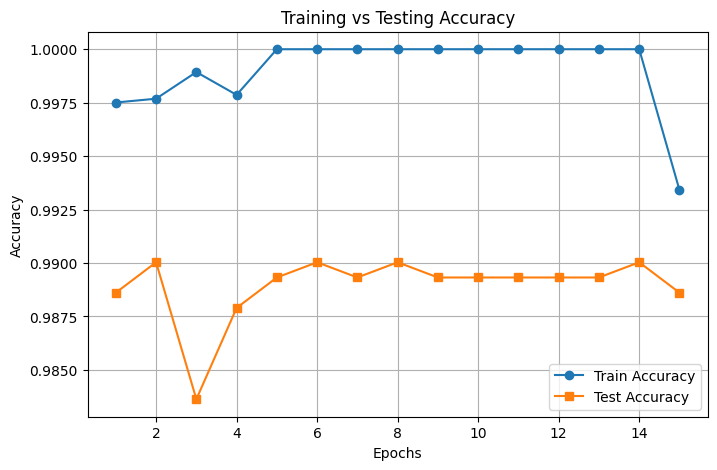

In [6]:
import matplotlib.pyplot as plt

# Lists to store accuracy per epoch
train_acc_list = []
test_acc_list = []

for epoch in range(EPOCHS):
    # -------- TRAINING --------
    model.train()
    correct = 0
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
    train_acc = correct / len(train_loader.dataset)
    train_acc_list.append(train_acc)

    # -------- TESTING --------
    model.eval()
    correct = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
    test_acc = correct / len(test_loader.dataset)
    test_acc_list.append(test_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

# -------- PLOTTING --------
plt.figure(figsize=(8,5))
plt.plot(range(1,EPOCHS+1), train_acc_list, marker='o', label="Train Accuracy")
plt.plot(range(1,EPOCHS+1), test_acc_list, marker='s', label="Test Accuracy")
plt.title("Training vs Testing Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()
